In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils.utils as utils
import utils.dataloaders as dataloaders
import torchvision
from utils.trainer import Trainer


### Dataset

In [11]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


## Task A
Create a CNN-model

In [12]:
def reset_seeds():
    torch.random.manual_seed(0)
    np.random.seed(0)

def get_n_params(model):
    return sum([param.nelement() for param in model.parameters()])


def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    reset_seeds()
    """ 
    fcnn_model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(32*32*1, 10)
    )
    """
    cnn_model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(1),
        nn.Linear(4*4*128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        # nn.Softmax()
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(cnn_model)
    
    # Print trainable parameters for confirming task 1e
    print(f"{get_n_params(model) = }")
    
    # This method prints a summary of the model
    from torchsummary import summary
    summary(model, input_size=(1, 32, 32))

    return model

model_a = create_model()

get_n_params(model) = 224970
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             832
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                   [-1, 64]         131,136
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total para

In [13]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model_a(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [14]:
# Hyperparameters
learning_rate = .02
num_epochs = 5

# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model_a.parameters(), lr=learning_rate)

### Train model

In [15]:
trainer = Trainer(
  model=model_a,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:24<00:00, 38.64it/s]


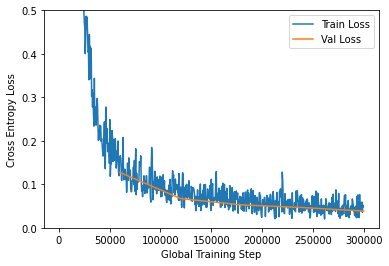

Final Test loss: 0.03849506264423268. Final Test accuracy: 0.9865


In [16]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(val_loss_dict, label="Val Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .5])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2a_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model_a, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

## Task B
Use the Adam optimizer

In [17]:
# Create model
model_b = create_model()
optimizer = torch.optim.Adam(model_b.parameters(), lr=0.001)

# Create trainer
trainer = Trainer(
  model=model_b,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_ADAM_loss_dict, val_ADAM_loss_dict = trainer.train(num_epochs)

get_n_params(model) = 224970
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             832
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                   [-1, 64]         131,136
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total para

Training epoch 4: 100%|██████████| 937/937 [00:24<00:00, 37.59it/s]


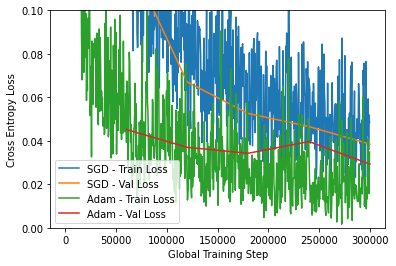

Final SGD Test loss: 0.03849506264423268. Final SGD Test accuracy: 0.9865
Final Adam Test loss: 0.029306549027838212. Final Adam Test accuracy: 0.9914


In [18]:
# Plot against task 2a
utils.plot_loss(train_loss_dict, label="SGD - Train Loss")
utils.plot_loss(val_loss_dict, label="SGD - Val Loss")
utils.plot_loss(train_ADAM_loss_dict, label="Adam - Train Loss")
utils.plot_loss(val_ADAM_loss_dict, label="Adam - Val Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 0.1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2b_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model_a, loss_function)
print(f"Final SGD Test loss: {final_loss}. Final SGD Test accuracy: {final_acc}")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model_b, loss_function)
print(f"Final Adam Test loss: {final_loss}. Final Adam Test accuracy: {final_acc}")